In [1]:
!pip install xhistogram==0.3.0
# !pip install xgcm==0.7

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41513")
client

<Client: 'tcp://127.0.0.1:41513' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:41513' processes=0 threads=0, memory=0 B>

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [5]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [6]:
cat = intake.open_catalog('../SWOT-AdAC/catalog.yaml')
entries = list(cat._entries.keys())
entries

['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32']

# Load data

In [7]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask()
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask()
enatl01s

<xarray.Dataset>
Dimensions:        (time_counter: 2208, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009...
Dimensions without coordinates: x, y
Data variables:
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

In [8]:
hycom01w = cat.HYCOM50(region='1_GS', datatype='surf', season='fma', decode_times=False).to_dask()
hycom01s = cat.HYCOM50(region='1_GS', datatype='surf', season='aso', decode_times=False).to_dask()

In [9]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/HYCOM50/"
hycom50_grids = {
    grid: xr.open_zarr(fs_osn.get_mapper(f"{url}{grid}.zarr"), consolidated=True)
    for grid in ["grid_01"]
}

hycom50_grids

{'grid_01': <xarray.Dataset>
 Dimensions:    (lat: 615, lon: 503)
 Dimensions without coordinates: lat, lon
 Data variables:
     depth      (lat, lon) float64 dask.array<chunksize=(615, 503), meta=np.ndarray>
     latitude   (lat) float64 dask.array<chunksize=(615,), meta=np.ndarray>
     longitude  (lon) float64 dask.array<chunksize=(503,), meta=np.ndarray>}

In [10]:
hycom25w = cat.HYCOM25(region='1', datatype='surface_hourly', season='fma', decode_times=False
                      ).to_dask().chunk({'time':100})
hycom25s = cat.HYCOM25(region='1', datatype='surface_hourly', season='aso', decode_times=False
                      ).to_dask().chunk({'time':100})
hycom25w

<xarray.Dataset>
Dimensions:     (X: 250, Y: 305, time: 2136)
Coordinates:
    lat         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
    lon         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
  * time        (time) int64 0 1 2 3 4 5 6 ... 2130 2131 2132 2133 2134 2135
Dimensions without coordinates: X, Y
Data variables:
    steric_ssh  (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    total_ssh   (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    u_0         (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    u_15        (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    v_0         (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    v_15        (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>

In [26]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
    
gigatl01w = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='fma').to_dask())
gigatl01s = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='aso').to_dask())

In [12]:
fesom01w = adjust_coords(cat.FESOM(datatype='surf', season='fma').to_dask())
fesom01s = adjust_coords(cat.FESOM(datatype='surf', season='aso').to_dask())

In [13]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()
print(model.varnames)

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']


In [14]:
istart = 497664
di = 144
dii = 50
itersw = np.arange(istart,int(istart+(29+31+30)*24*di),di)
iis = 25
print(itersw[iis*dii],itersw[iis*dii+dii])

677664 684864


In [8]:
for ii in range(iis,len(itersw[::dii])): #before 4, dii = 100
    
    llc01w = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                               iters=itersw[ii*dii:ii*dii+dii],
                               type='latlon'
                              ).sel(
    #                                               time=slice('2012-02-01','2012-04-30'),
                                    j=slice(9555,10198),j_g=slice(9555,10198),
                                    i=slice(15355,15845),i_g=slice(15355,15845),
                                   ).isel(k=0,k_l=0,k_u=0,k_p1=0
                                         ).chunk({'j':200,'i':200,'j_g':200,'i_g':200})
    metrics = {
        ('X',): ['dxC', 'dxG'], # X distances
        ('Y',): ['dyC', 'dyG'], # Y distances
    #     ('Z',): ['drC'], # Z distances
        ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
    }

    gridllc = Grid(llc01w, periodic=[],
                   coords={
    #                    'Z':{'center':'k','outer':'k_p1'},
                           'Y':{'center':'j','left':'j_g'},
                           'X':{'center':'i','left':'i_g'}},
                   metrics=metrics
                  )
    vorllcw = ((gridllc.diff(llc01w.V * llc01w.dyC,'X',boundary='extend') 
                - gridllc.diff(llc01w.U * llc01w.dxC,'Y',boundary='extend')
               ) / llc01w.rAz
              ).reset_coords(drop=True)
    divllcw = ((gridllc.diff(llc01w.V * llc01w.dxG,'Y',boundary='extend') 
                + gridllc.diff(llc01w.U * llc01w.dyG,'X',boundary='extend')
               ) / llc01w.rA
              ).reset_coords(drop=True)
    strllcw = np.sqrt(((gridllc.diff(llc01w.U * llc01w.dyG,'X',boundary='extend') 
                        - gridllc.diff(llc01w.V * llc01w.dxG,'Y',boundary='extend')
                       ) / llc01w.rA)**2 
                      + gridllc.interp(gridllc.interp(((gridllc.diff(llc01w.U * llc01w.dxC,'Y',boundary='extend') 
                                                        + gridllc.diff(llc01w.V * llc01w.dyC,'X',boundary='extend') 
                                                       ) / llc01w.rAz)**2,
                                                      'Y',boundary='fill'),
                                       'X',boundary='fill')
                     ).reset_coords(drop=True)
#     print(strllcw)
    
    if ii*dii+dii-1 < len(iters):
        tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_fma_%010d-%010d.zarr' % (iters[ii*dii],iters[ii*dii+dii-1])
    else:
        tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_fma_%010d-%010d.zarr' % (iters[ii*dii],iters[-1])
    store_tmp = gcs.get_mapper(tmp_path)
    dsave = vorllcw.to_dataset(name='vort')
    dsave['div'] = divllcw
    dsave['strain'] = strllcw
    dsave.vort.encoding = {}
    dsave.div.encoding = {}
    dsave.strain.encoding = {}
    dsave.chunk({'j':200,'i':200,'j_g':200,'i_g':200}).to_zarr(store_tmp, mode='w')
    dsave.close()
    llc01w.close()
    print(tmp_path)
    
# llc01w = model.get_dataset(varnames=['U','V'], k_levels=[0], 
#                            type='latlon').sel(time=slice('2012-02-01','2012-04-30'),
#                                               j=slice(4778,5098),j_g=slice(4778,5098),
#                                               i=slice(7679,7920),i_g=slice(7679,7920)
#                                              ).isel(k=0)
# llc01w

gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000677664-0000684720.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000684864-0000691920.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000692064-0000699120.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000699264-0000706320.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000706464-0000713520.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000713664-0000720720.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000720864-0000727920.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000728064-0000735120.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000735264-0000742320.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000742464-0000749520.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000749664-0000

In [15]:
di = 144
istart = 497664+(29+31+30+31+30+31)*24*di
dii = 50
iterss = np.arange(istart,int(istart+(31+30+31)*24*di),di)
iis = 18
print(iterss[iis*dii],iterss[iis*dii+dii])

1256256 1263456


In [11]:
for ii in range(iis+1,len(iterss[::dii])): 
    
    llc01s = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                               iters=iterss[ii*dii:ii*dii+dii],
                               type='latlon'
                              ).sel(
    #                                               time=slice('2012-02-01','2012-04-30'),
                                    j=slice(9555,10198),j_g=slice(9555,10198),
                                    i=slice(15355,15845),i_g=slice(15355,15845),
                                   ).isel(k=0,k_l=0,k_u=0,k_p1=0
                                         ).chunk({'j':200,'i':200,'j_g':200,'i_g':200})
    metrics = {
        ('X',): ['dxC', 'dxG'], # X distances
        ('Y',): ['dyC', 'dyG'], # Y distances
    #     ('Z',): ['drC'], # Z distances
        ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
    }

    gridllc = Grid(llc01s, periodic=[],
                   coords={
    #                    'Z':{'center':'k','outer':'k_p1'},
                           'Y':{'center':'j','left':'j_g'},
                           'X':{'center':'i','left':'i_g'}},
                   metrics=metrics
                  )
    vorllcs = ((gridllc.diff(llc01s.V * llc01s.dyC,'X',boundary='extend') 
                - gridllc.diff(llc01s.U * llc01s.dxC,'Y',boundary='extend')
               ) / llc01s.rAz
              ).reset_coords(drop=True)
    divllcs = ((gridllc.diff(llc01s.V * llc01s.dxG,'Y',boundary='extend') 
                + gridllc.diff(llc01s.U * llc01s.dyG,'X',boundary='extend')
               ) / llc01s.rA
              ).reset_coords(drop=True)
    strllcs = np.sqrt(((gridllc.diff(llc01s.U * llc01s.dyG,'X',boundary='extend') 
                        - gridllc.diff(llc01s.V * llc01s.dxG,'Y',boundary='extend')
                       ) / llc01s.rA)**2 
                      + gridllc.interp(gridllc.interp(((gridllc.diff(llc01s.U * llc01s.dxC,'Y',boundary='extend') 
                                                        + gridllc.diff(llc01s.V * llc01s.dyC,'X',boundary='extend') 
                                                       ) / llc01s.rAz)**2,
                                                      'Y',boundary='fill'),
                                       'X',boundary='fill')
                     ).reset_coords(drop=True)
#     print(strllcw)
    
    if ii*dii+dii-1 < len(iters):
        tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_aso_%010d-%010d.zarr' % (iters[ii*dii],iters[ii*dii+dii-1])
    else:
        tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_aso_%010d-%010d.zarr' % (iters[ii*dii],iters[-1])
    store_tmp = gcs.get_mapper(tmp_path)
    dsave = vorllcs.to_dataset(name='vort')
    dsave['div'] = divllcs
    dsave['strain'] = strllcs
    dsave.vort.encoding = {}
    dsave.div.encoding = {}
    dsave.strain.encoding = {}
    dsave.chunk({'j':200,'i':200,'j_g':200,'i_g':200}).to_zarr(store_tmp, mode='w')
    dsave.close()
    llc01s.close()
    print(tmp_path)
    
# llc01s = model.get_dataset(varnames=['U','V'], k_levels=[0], 
#                            type='latlon').sel(time=slice('2011-08-01','2011-10-31'),
#                                               j=slice(4778,5098),j_g=slice(4778,5098),
#                                               i=slice(7679,7920),i_g=slice(7679,7920)
#                                              )
# llc01s

gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001263456-0001270512.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001270656-0001277712.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001277856-0001284912.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001285056-0001292112.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001292256-0001299312.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001299456-0001306512.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001306656-0001313712.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001313856-0001320912.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001321056-0001328112.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001328256-0001335312.zarr
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001335456-0001

In [16]:
llc01w = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                           iters=[itersw[0]],
                           type='latlon'
                          ).sel(
    #                                               time=slice('2012-02-01','2012-04-30'),
                                j=slice(9555,10198),j_g=slice(9555,10198),
                                i=slice(15355,15845),i_g=slice(15355,15845),
                               ).isel(k=0,k_l=0,k_u=0,k_p1=0
                                     ).chunk({'j':200,'i':200,'j_g':200,'i_g':200})

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
#     ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridllc = Grid(llc01w, periodic=[],
               coords={
#                    'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )
gridllc

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

In [17]:
llcfC = xr.apply_ufunc(gsw.f,llc01w.YC,dask='parallelized')
llcfG = xr.apply_ufunc(gsw.f,llc01w.YG,dask='parallelized')
llcfG

<xarray.DataArray 'YG' (j_g: 644, i_g: 491)>
dask.array<transpose, shape=(644, 491), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates: (12/20)
  * i_g      (i_g) int64 15355 15356 15357 15358 ... 15842 15843 15844 15845
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
    k        int64 0
    k_u      int64 0
    k_l      int64 0
    k_p1     int64 0
    ...       ...
    XG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    Zl       >f4 dask.array<chunksize=(), meta=np.ndarray>
    Zu       >f4 dask.array<chunksize=(), meta=np.ndarray>

In [18]:
fio01w = cat['FIO-COM32'](region='1',datatype='surface_hourly', season='fma').to_dask()
fio01s = cat['FIO-COM32'](region='1',datatype='surface_hourly', season='aso').to_dask()
fio01grid = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/grid.zarr"))
fio01grid

<xarray.Dataset>
Dimensions:            (XT_OCEAN6465_6784: 320, XU_OCEAN6464_6784: 321, YT_OCEAN3585_3904: 320, YU_OCEAN3584_3904: 321)
Coordinates:
  * XT_OCEAN6465_6784  (XT_OCEAN6465_6784) float64 -77.98 -77.95 ... -68.02
  * XU_OCEAN6464_6784  (XU_OCEAN6464_6784) float64 -78.0 -77.97 ... -68.03 -68.0
  * YT_OCEAN3585_3904  (YT_OCEAN3585_3904) float64 30.02 30.05 ... 39.95 39.98
  * YU_OCEAN3584_3904  (YU_OCEAN3584_3904) float64 30.0 30.03 ... 39.97 40.0
Data variables:
    DXC                (YU_OCEAN3584_3904, XU_OCEAN6464_6784) float32 dask.array<chunksize=(161, 321), meta=np.ndarray>
    DXT                (YT_OCEAN3585_3904, XT_OCEAN6465_6784) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    DYC                (YU_OCEAN3584_3904, XU_OCEAN6464_6784) float32 dask.array<chunksize=(161, 321), meta=np.ndarray>
    DYT                (YT_OCEAN3585_3904, XT_OCEAN6465_6784) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>

# Vorticity and strain

In [19]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def nemo_vort(u, v, e1f, e2f, e2v, e1u):
    return (
        diff(v * e2v, 1, axis=-1)
        - diff(u * e1u, 1, axis=-2)
    ) / (e1f  * e2f)

def nemo_div(u, v, e1t, e2t, e1v, e2u):
    return (
        diff(v * e1v, 1, axis=-2)
        + diff(u * e2u, 1, axis=-1)
    ) / (e1t  * e2t)

def nemo_str(u, v, e1t, e2t, e2u, e1v, e1f, e2f, e1u, e2v):
    str1 = (diff(u * e2u, 1, axis=-1)
            - diff(v * e1v, 1, axis=-2)
           ) / (e1t  * e2t)
    str2 = (diff(u * e1u, 1, axis=-2)
            + diff(v * e2v, 1, axis=-1)
           ) / (e1f  * e2f)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

def t_to_f(da):
    return (.25*(da 
                + np.roll(da,1,-1) 
                + np.roll(da,1,-2)
                + np.roll(np.roll(da,1,-1),1,-2)
               )
    )

In [20]:
enatlf = xr.apply_ufunc(gsw.f, enatl01w.lat, dask='parallelized')

vorenatlw = xr.apply_ufunc(
    nemo_vort,
    enatl01w.sozocrtx[::12], 
    enatl01w.somecrty[::12], 
    enatl01w.e1f, enatl01w.e2f,
    enatl01w.e2v, enatl01w.e1u,
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divenatlw = xr.apply_ufunc(
#     nemo_div,
#     enatl01w.sozocrtx[::12], 
#     enatl01w.somecrty[::12], 
#     enatl01w.e1t, enatl01w.e2t,
#     enatl01w.e1v, enatl01w.e2u,
#     input_core_dims = 6 * [['y', 'x']],    # 6 inputs
#     output_core_dims = [['y', 'x']],
#     output_dtypes=[enatl01w.sozocrtx.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strenatlw = xr.apply_ufunc(
    nemo_str,
    enatl01w.sozocrtx[::12], 
    enatl01w.somecrty[::12], 
    enatl01w.e1t, enatl01w.e2t,
    enatl01w.e2u, enatl01w.e1v,
    enatl01w.e1f, enatl01w.e2f,
    enatl01w.e1u, enatl01w.e2v,
    input_core_dims = 10 * [['y', 'x']],   # 10 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strenatlw

<xarray.DataArray 'strain' (time_counter: 178, y: 763, x: 611)>
dask.array<transpose, shape=(178, 763, 611), dtype=float32, chunksize=(6, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-...
Dimensions without coordinates: y, x

In [21]:
vorenatls = xr.apply_ufunc(
    nemo_vort,
    enatl01s.sozocrtx[::12], 
    enatl01s.somecrty[::12], 
    enatl01s.e1f, enatl01s.e2f,
    enatl01s.e2v, enatl01s.e1u,
    input_core_dims = 6 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divenatls = xr.apply_ufunc(
#     nemo_div,
#     enatl01s.sozocrtx[::12], 
#     enatl01s.somecrty[::12], 
#     enatl01s.e1t, enatl01s.e2t,
#     enatl01s.e1v, enatl01s.e2u,
#     input_core_dims = 6 * [['y', 'x']],    # 6 inputs
#     output_core_dims = [['y', 'x']],
#     output_dtypes=[enatl01s.sozocrtx.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strenatls = xr.apply_ufunc(
    nemo_str,
    enatl01s.sozocrtx[::12], 
    enatl01s.somecrty[::12], 
    enatl01s.e1t, enatl01s.e2t,
    enatl01s.e2u, enatl01s.e1v,
    enatl01s.e1f, enatl01s.e2f,
    enatl01s.e1u, enatl01s.e2v,
    input_core_dims = 10 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strenatls

<xarray.DataArray 'strain' (time_counter: 184, y: 763, x: 611)>
dask.array<transpose, shape=(184, 763, 611), dtype=float32, chunksize=(6, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009-...
Dimensions without coordinates: y, x

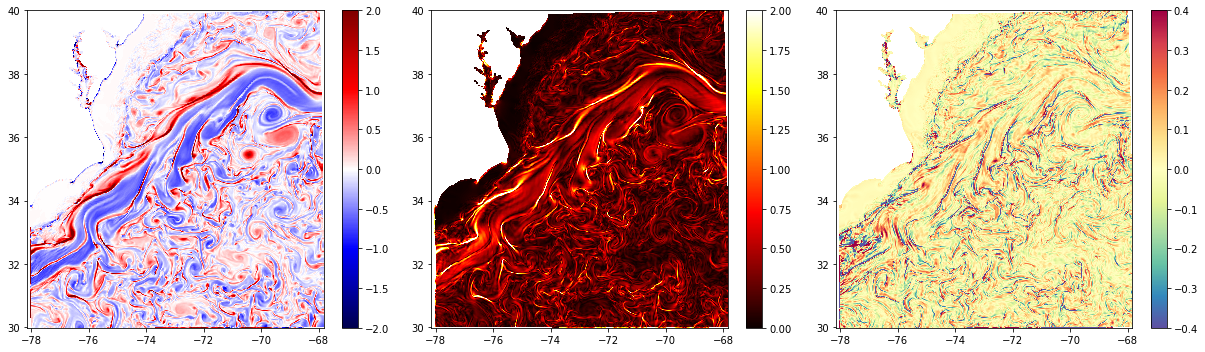

In [57]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(enatl01w.lon, enatl01w.lat, vorenatlw.isel(time_counter=0)/enatlf, 
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolormesh(enatl01w.lon, enatl01w.lat, strenatlw.isel(time_counter=0)/enatlf, 
                     cmap='hot', vmin=0, vmax=2, rasterized=True)
im3 = ax3.pcolormesh(enatl01w.lon, enatl01w.lat, divenatlw.isel(time_counter=0)/enatlf, 
                     cmap='Spectral_r', vmax=.4, vmin=-.4, rasterized=True)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

In [27]:
gigatl01w = gigatl01w.isel(time=np.arange(0,2280,12)).chunk({'xi_u':100,'eta_rho':100,
                                                             'xi_rho':100,'eta_v':100})
gridg = gigatl01w.attrs["xgcm-Grid"]

mask_rho = gigatl01w.salt.where(gigatl01w.salt==0.).isel(time=0)
mask_u = gridg.interp(mask_rho, 'xi')
mask_v = gridg.interp(mask_rho, 'eta')
mask_psi = gridg.interp(gridg.interp(mask_rho, 'eta'), 'xi')
gigaf = gridg.interp(gridg.interp(gigatl01w.f.where(mask_rho!=0.), 'eta'), 'xi')


pm_psi = gridg.interp(gridg.interp(gigatl01w.pm, 'eta'), 'xi') # at psi points (eta_v, xi_u) 
pn_psi = gridg.interp(gridg.interp(gigatl01w.pn, 'xi'), 'eta') # at psi points (eta_v, xi_u)

dudy = gridg.diff(gigatl01w.u.where(mask_u!=0.), 'eta') * pn_psi
dudx = gridg.diff(gigatl01w.u.where(mask_u!=0.), 'xi', boundary='extend') * gigatl01w.pm
dvdx = gridg.diff(gigatl01w.v.where(mask_v!=0.), 'xi') * pm_psi
dvdy = gridg.diff(gigatl01w.v.where(mask_v!=0.), 'eta', boundary='extend') * gigatl01w.pn


vorgigaw = (dvdx - dudy).rename('vort').compute().chunk({'time':10})
strgigaw = np.sqrt(gridg.interp(gridg.interp((dudx - dvdy)**2,'xi'),'eta') 
                   + (dudy + dvdx)**2
                  ).rename('strain').compute().chunk({'time':10})
divgigaw = (dudx + dvdy).rename('div')
strgigaw

<xarray.DataArray 'strain' (time: 190, eta_v: 1488, xi_u: 1490)>
dask.array<xarray-<this-array>, shape=(190, 1488, 1490), dtype=float32, chunksize=(10, 1488, 1490), chunktype=numpy.ndarray>
Dimensions without coordinates: time, eta_v, xi_u

In [31]:
gigatl01s = gigatl01s.isel(time=np.arange(0,2280,12)).chunk({'xi_u':100,'eta_rho':100,
                                                             'xi_rho':100,'eta_v':100})
gridg = gigatl01s.attrs["xgcm-Grid"]


dudy = gridg.diff(gigatl01s.u.where(mask_u!=0.), 'eta') * pn_psi
dudx = gridg.diff(gigatl01s.u.where(mask_u!=0.), 'xi', boundary='extend') * gigatl01s.pm
dvdx = gridg.diff(gigatl01s.v.where(mask_v!=0.), 'xi') * pm_psi
dvdy = gridg.diff(gigatl01s.v.where(mask_v!=0.), 'eta', boundary='extend') * gigatl01s.pn


vorgigas = (dvdx - dudy).rename('vort').compute().chunk({'time':10})
strgigas = np.sqrt(gridg.interp(gridg.interp((dudx - dvdy)**2,'xi'),'eta') 
                   + (dudy + dvdx)**2
                  ).rename('strain').compute().chunk({'time':10})
# divgigas = (dudx + dvdy).rename('div')
# divgigas

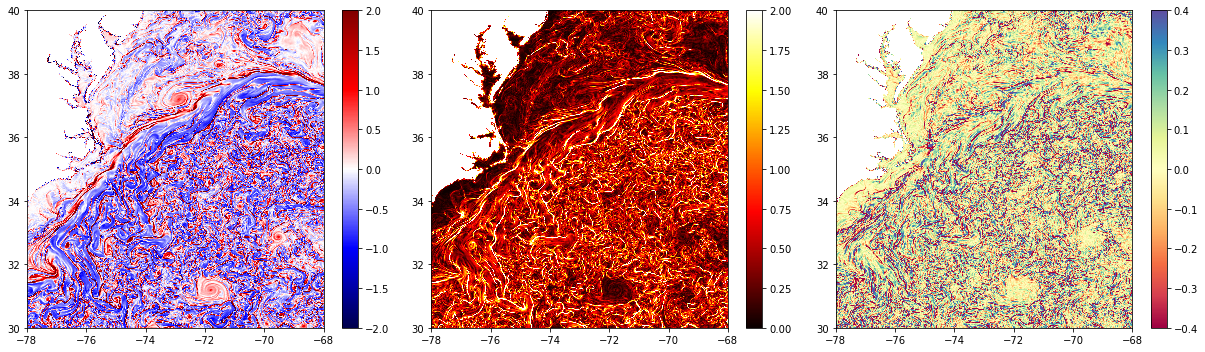

In [61]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(gigatl01w.lon, gigatl01w.lat, vorgigaw.isel(time=0)/gigaf,
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolormesh(gigatl01w.lon, gigatl01w.lat, strgigaw.isel(time=0)/gigaf, 
                     cmap='hot', vmax=2, vmin=0., rasterized=True)
im3 = ax3.pcolormesh(gigatl01w.lon, gigatl01w.lat, 
                     gridg.interp(gridg.interp(divgigaw.isel(time=0),'xi'),'eta')/gigaf, 
                     cmap='Spectral', vmax=.4, vmin=-.4, rasterized=True)

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])
ax3.set_xlim([-78,-68])
ax3.set_ylim([30,40])

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

In [29]:
for ii in range(len(itersw[::dii])):
    if ii < 4:
        if ii == 0:
            fname = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_fma_%010d-%010d.zarr' % (itersw[0],itersw[100-1])
        elif ii == 2:
            fname = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_fma_%010d-%010d.zarr' % (itersw[100],itersw[200-1])
    elif ii*dii+dii-1 < len(itersw):
        fname = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_fma_%010d-%010d.zarr' % (itersw[ii*dii],itersw[ii*dii+dii-1])
    else:
        fname = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_fma_%010d-%010d.zarr' % (itersw[ii*dii],itersw[-1])
    if ii == 0:
        print(fname)
        vorllcw = xr.open_zarr(gcs.get_mapper(fname)).vort
#         divllcw = xr.open_zarr(gcs.get_mapper(fname)).div
        strllcw = xr.open_zarr(gcs.get_mapper(fname)).strain
    else:
        vorllcw = xr.concat([vorllcw,xr.open_zarr(gcs.get_mapper(fname)).vort], 'time')
#         divllcw = xr.concat([divllcw,xr.open_zarr(gcs.get_mapper(fname)).div], 'time')
        strllcw = xr.concat([strllcw,xr.open_zarr(gcs.get_mapper(fname)).strain], 'time')
vorllcw

gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_fma_0000497664-0000511920.zarr


<xarray.DataArray 'vort' (time: 2360, j_g: 644, i_g: 491)>
dask.array<concatenate, shape=(2360, 644, 491), dtype=float32, chunksize=(100, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 15355 15356 15357 15358 ... 15842 15843 15844 15845
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00

In [30]:
for ii in range(len(iterss[::dii])):
    if ii*dii+dii-1 < len(iterss):
        fname = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_aso_%010d-%010d.zarr' % (iterss[ii*dii],iterss[ii*dii+dii-1])
    else:
        fname = f'{SCRATCH}/region01/LLC4320/'+f'Vort-div-str_aso_%010d-%010d.zarr' % (iterss[ii*dii],iterss[-1])
    if ii == 0:
        print(fname)
        vorllcs = xr.open_zarr(gcs.get_mapper(fname)).vort
#         divllcs = xr.open_zarr(gcs.get_mapper(fname)).div
        strllcs = xr.open_zarr(gcs.get_mapper(fname)).strain
    else:
        vorllcs = xr.concat([vorllcs,xr.open_zarr(gcs.get_mapper(fname)).vort], 'time')
#         divllcs = xr.concat([divllcs,xr.open_zarr(gcs.get_mapper(fname)).div], 'time')
        strllcs = xr.concat([strllcs,xr.open_zarr(gcs.get_mapper(fname)).strain], 'time')
vorllcs

gcs://meom-ige-scratch/roxyboy/region01/LLC4320/Vort-div-str_aso_0001126656-0001133712.zarr


<xarray.DataArray 'vort' (time: 2208, j_g: 644, i_g: 491)>
dask.array<concatenate, shape=(2208, 644, 491), dtype=float32, chunksize=(1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 15355 15356 15357 15358 ... 15842 15843 15844 15845
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
  * time     (time) datetime64[ns] 2012-08-01 ... 2012-10-31T23:00:00

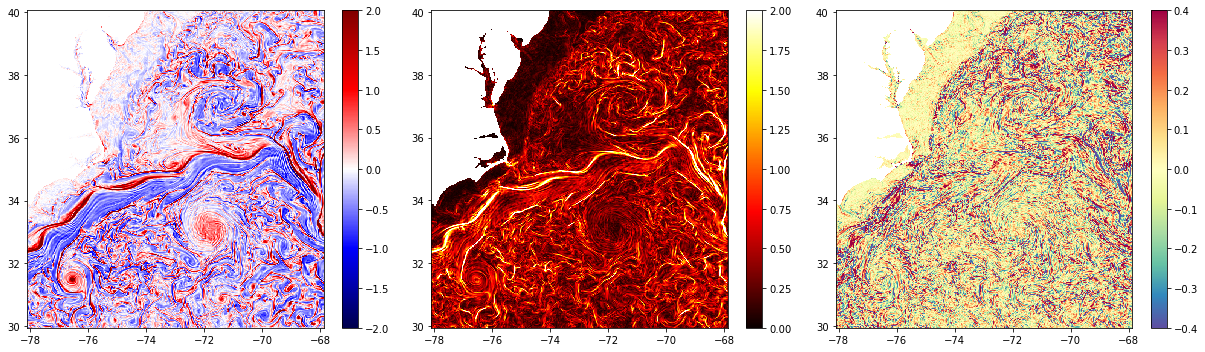

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(llc01w.XG, llc01w.YG, vorllcw.isel(time=0)/llcfG, 
                     cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(llc01w.XC, llc01w.YC, strllcw.isel(time=0)/llcfC, 
                     cmap='hot', vmax=2, vmin=0.)
im3 = ax3.pcolormesh(llc01w.XC, llc01w.YC, divllcw.isel(time=0)/llcfC, 
                     cmap='Spectral_r', vmax=.4, vmin=-.4)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

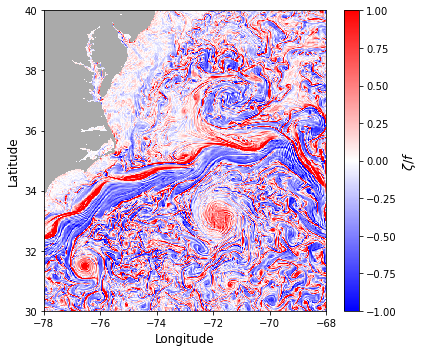

In [18]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(llc01w.XG, llc01w.YG, np.ma.masked_invalid(vorllcw.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True, shading='auto')
im = ax.pcolormesh(llc01w.XG, llc01w.YG, vorllcw.isel(time=0)/llcfG, 
                   cmap='bwr', vmax=1., vmin=-1., rasterized=True, shading='auto')

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-LLC4320_01.pdf')

In [32]:
Ny = len(hycom50_grids["grid_01"].lat)
Nx = len(hycom50_grids["grid_01"].lon)
import gsw
xx, yy = np.meshgrid(hycom50_grids["grid_01"].longitude, hycom50_grids["grid_01"].latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

hycom01w.coords['dx'] = (('lat','lon'), dx.data)
hycom01w.coords['dy'] = (('lat','lon'), dy.data)

hycom01s.coords['dx'] = (('lat','lon'), dx.data)
hycom01s.coords['dy'] = (('lat','lon'), dy.data)
hycom01s

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503, time: 2208)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2201 2202 2203 2204 2205 2206 2207
    dx         (lat, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dy         (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sss        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    vv1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>

In [33]:
hycomf = xr.apply_ufunc(gsw.f, hycom01w.latitude, dask='parallelized')
hycomf

<xarray.DataArray 'latitude' (lat: 615)>
dask.array<transpose, shape=(615,), dtype=float64, chunksize=(615,), chunktype=numpy.ndarray>
Dimensions without coordinates: lat

In [34]:
def t_vort(u, v, dx, dy):
    return (
        diff(v * dy, 1, axis=-1)
        - diff(u * dx, 1, axis=-2)
    ) / (dx * dy)

def t_div(u, v, dx, dy):
    return (
        diff(v * dx, 1, axis=-2)
        + diff(u * dy, 1, axis=-1)
    ) / (dx * dy)

def t_str(u, v, dx, dy):
    str1 = (diff(u * dy, 1, axis=-1)
            - diff(v * dx, 1, axis=-2)
           ) / (dy * dx)
    str2 = (diff(u * dx, 1, axis=-2)
            + diff(v * dy, 1, axis=-1)
           ) / (dy * dx)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

In [35]:
vorhycomw = xr.apply_ufunc(
    t_vort,
    hycom01w.uu1[::12], 
    hycom01w.vv1[::12], 
    hycom01w.dx, hycom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01w.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divhycomw = xr.apply_ufunc(
#     t_div,
#     hycom01w.uu1[::12], 
#     hycom01w.vv1[::12], 
#     hycom01w.dx, hycom01w.dy,
#     input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[hycom01w.uu1.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strhycomw = xr.apply_ufunc(
    t_str,
    hycom01w.uu1[::12], 
    hycom01w.vv1[::12], 
    hycom01w.dx, hycom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01w.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strhycomw

<xarray.DataArray 'strain' (time: 180, lat: 615, lon: 503)>
dask.array<transpose, shape=(180, 615, 503), dtype=float32, chunksize=(2, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2088 2100 2112 2124 2136 2148
Dimensions without coordinates: lat, lon

In [36]:
vorhycoms = xr.apply_ufunc(
    t_vort,
    hycom01s.uu1[::12], 
    hycom01s.vv1[::12], 
    hycom01s.dx, hycom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01s.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divhycoms = xr.apply_ufunc(
#     t_div,
#     hycom01s.uu1[::12], 
#     hycom01s.vv1[::12], 
#     hycom01s.dx, hycom01s.dy,
#     input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[hycom01s.uu1.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strhycoms = xr.apply_ufunc(
    t_str,
    hycom01s.uu1[::12], 
    hycom01s.vv1[::12], 
    hycom01s.dx, hycom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom01s.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strhycoms

<xarray.DataArray 'strain' (time: 184, lat: 615, lon: 503)>
dask.array<transpose, shape=(184, 615, 503), dtype=float32, chunksize=(2, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2136 2148 2160 2172 2184 2196
Dimensions without coordinates: lat, lon

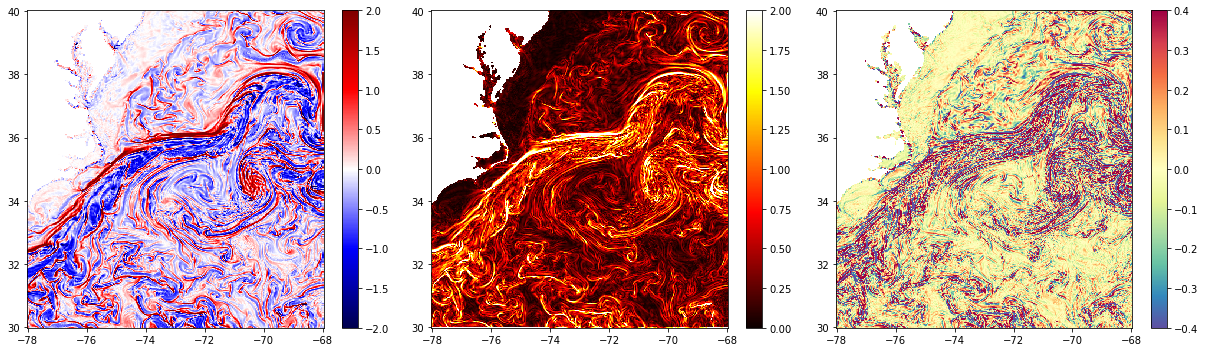

In [56]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(hycom50_grids["grid_01"].longitude, hycom50_grids["grid_01"].latitude, 
                     vorhycomw.isel(time=0)/hycomf, cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(hycom50_grids["grid_01"].longitude, hycom50_grids["grid_01"].latitude, 
                     strhycomw.isel(time=0)/hycomf, cmap='hot', vmin=0., vmax=2)
im3 = ax3.pcolormesh(hycom50_grids["grid_01"].longitude, hycom50_grids["grid_01"].latitude, 
                     divhycomw.isel(time=0)/hycomf, cmap='Spectral_r', vmin=-.4, vmax=.4)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

In [37]:
Ny = len(hycom25w.Y)
Nx = len(hycom25w.X)
import gsw
# xx, yy = np.meshgrid(hycom25w.lon, hycom25w.lat)
dx = xr.DataArray(gsw.distance(hycom25w.lon, hycom25w.lat), dims=['Y','X'],
                  coords={'Y':np.arange(Ny),'X':np.arange(.5,Nx-1,1)}
                 ).interp(X=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(hycom25w.lon, hycom25w.lat, axis=0), dims=['Y','X'],
                  coords={'Y':np.arange(.5,Ny-1,1),'X':np.arange(Nx)}
                 ).interp(Y=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

hycom25w.coords['dx'] = (('Y','X'), dx.data)
hycom25w.coords['dy'] = (('Y','X'), dy.data)

hycom25s.coords['dx'] = (('Y','X'), dx.data)
hycom25s.coords['dy'] = (('Y','X'), dy.data)
hycom25w

<xarray.Dataset>
Dimensions:     (X: 250, Y: 305, time: 2136)
Coordinates:
    lat         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
    lon         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
  * time        (time) int64 0 1 2 3 4 5 6 ... 2130 2131 2132 2133 2134 2135
    dx          (Y, X) float64 3.861e+03 3.85e+03 ... 3.408e+03 3.398e+03
    dy          (Y, X) float64 3.852e+03 3.852e+03 ... 3.409e+03 3.409e+03
Dimensions without coordinates: X, Y
Data variables:
    steric_ssh  (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    total_ssh   (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    u_0         (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    u_15        (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    v_0         (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>
    v_15        (time, Y, X) float32 dask.array<chunksize=(100, 305, 250), meta=np.ndarray>

In [38]:
hycomf_25 = xr.apply_ufunc(gsw.f, hycom25w.lat, dask='parallelized')
hycomf_25

<xarray.DataArray 'lat' (Y: 305, X: 250)>
dask.array<transpose, shape=(305, 250), dtype=float64, chunksize=(305, 250), chunktype=numpy.ndarray>
Coordinates:
    lat      (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
    lon      (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
    dx       (Y, X) float64 3.861e+03 3.85e+03 3.85e+03 ... 3.408e+03 3.398e+03
    dy       (Y, X) float64 3.852e+03 3.852e+03 ... 3.409e+03 3.409e+03
Dimensions without coordinates: Y, X

In [39]:
vorhycom25w = xr.apply_ufunc(
    t_vort,
    hycom25w.u_0[::12], 
    hycom25w.v_0[::12], 
    hycom25w.dx, hycom25w.dy,
    input_core_dims = 4 * [['Y','X']],    # 4 inputs
    output_core_dims = [['Y','X']],
    output_dtypes=[hycom25w.u_15.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divhycomw = xr.apply_ufunc(
#     t_div,
#     hycom01w.uu1[::12], 
#     hycom01w.vv1[::12], 
#     hycom01w.dx, hycom01w.dy,
#     input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[hycom01w.uu1.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strhycom25w = xr.apply_ufunc(
    t_str,
    hycom25w.u_0[::12], 
    hycom25w.v_0[::12], 
    hycom25w.dx, hycom25w.dy,
    input_core_dims = 4 * [['Y', 'X']],   # 4 inputs
    output_core_dims = [['Y', 'X']],
    output_dtypes=[hycom25w.u_15.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
vorhycom25w

<xarray.DataArray 'vort' (time: 178, Y: 305, X: 250)>
dask.array<transpose, shape=(178, 305, 250), dtype=float32, chunksize=(9, 305, 250), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2064 2076 2088 2100 2112 2124
Dimensions without coordinates: Y, X

In [40]:
vorhycom25s = xr.apply_ufunc(
    t_vort,
    hycom25s.u_0[::12], 
    hycom25s.v_0[::12], 
    hycom25s.dx, hycom25s.dy,
    input_core_dims = 4 * [['Y','X']],    # 4 inputs
    output_core_dims = [['Y','X']],
    output_dtypes=[hycom25s.u_15.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divhycomw = xr.apply_ufunc(
#     t_div,
#     hycom01w.uu1[::12], 
#     hycom01w.vv1[::12], 
#     hycom01w.dx, hycom01w.dy,
#     input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[hycom01w.uu1.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strhycom25s = xr.apply_ufunc(
    t_str,
    hycom25s.u_0[::12], 
    hycom25s.v_0[::12], 
    hycom25s.dx, hycom25s.dy,
    input_core_dims = 4 * [['Y', 'X']],   # 4 inputs
    output_core_dims = [['Y', 'X']],
    output_dtypes=[hycom25s.u_15.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
vorhycom25s

<xarray.DataArray 'vort' (time: 184, Y: 305, X: 250)>
dask.array<transpose, shape=(184, 305, 250), dtype=float32, chunksize=(9, 305, 250), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2136 2148 2160 2172 2184 2196
Dimensions without coordinates: Y, X

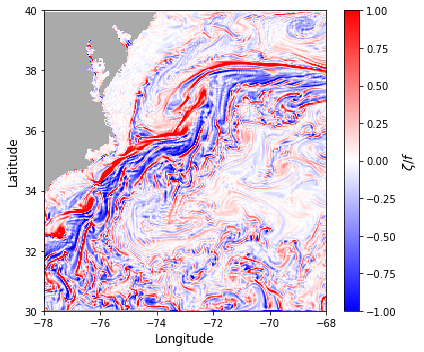

In [18]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(hycom25w.lon, hycom25w.lat, 
              np.ma.masked_invalid(vorhycom25w.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, shading='auto', rasterized=True)
im = ax.pcolormesh(hycom25w.lon, hycom25w.lat, 
                   vorhycom25w.isel(time=0)/hycomf_25, 
                   cmap='bwr', vmax=1, vmin=-1, shading='auto', rasterized=True)

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-HYCOM25_01.pdf')

In [41]:
def fesom_vort(u, v, dx, dy):
    vx = diff(v * dy, 1, axis=-1)
    uy = diff(u * dx, 1, axis=-2)
    vx = .25*(vx 
              + np.roll(vx,1,-1) 
              + np.roll(vx,1,-2)
              + np.roll(np.roll(vx,1,-1),1,-2)
             )
    uy = .25*(uy 
              + np.roll(uy,1,-1) 
              + np.roll(uy,1,-2)
              + np.roll(np.roll(uy,1,-1),1,-2)
             )
    return (vx - uy) / (dx * dy)

# def f_div(u, v, dx, dy):
    
#     return (
#         diff(v * dx, 1, axis=-2)
#         + diff(u * dy, 1, axis=-1)
#     ) / (dx * dy)

def fesom_str(u, v, dx, dy):
    str1 = (diff(u * dy, 1, axis=-1)
            - diff(v * dx, 1, axis=-2)
           ) / (dy * dx)
    str2 = (diff(u * dx, 1, axis=-2)
            + diff(v * dy, 1, axis=-1)
           ) / (dy * dx)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

In [42]:
Ny = len(fesom01s.lat)
Nx = len(fesom01s.lon)
import gsw
xx, yy = np.meshgrid(fesom01s.lon, fesom01s.lat)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

fesom01w.coords['dx'] = (('lat','lon'), dx.data)
fesom01w.coords['dy'] = (('lat','lon'), dy.data)

fesom01s.coords['dx'] = (('lat','lon'), dx.data)
fesom01s.coords['dy'] = (('lat','lon'), dy.data)
fesom01s

<xarray.Dataset>
Dimensions:  (lat: 1000, lon: 1000, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-08-01 ... 2012-10-31T23:00:00
    dx       (lat, lon) float64 963.9 963.9 963.9 963.9 ... 852.7 852.7 852.7
    dy       (lat, lon) float64 1.113e+03 1.113e+03 ... 1.113e+03 1.113e+03
Data variables:
    dflux    (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    ssh      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    sss      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    sst      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    tx_sur   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    ty_sur   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    u_surf   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    v_surf   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (not periodic, boundary=None):\n  * cent...

In [43]:
fesomf = xr.apply_ufunc(gsw.f, fesom01w.lat, dask='parallelized')
fesomf

<xarray.DataArray 'lat' (lat: 1000)>
array([7.29211500e-05, 7.29432150e-05, 7.29652778e-05, 7.29873383e-05,
       7.30093967e-05, 7.30314528e-05, 7.30535066e-05, 7.30755583e-05,
       7.30976077e-05, 7.31196549e-05, 7.31416998e-05, 7.31637425e-05,
       7.31857830e-05, 7.32078213e-05, 7.32298573e-05, 7.32518911e-05,
       7.32739226e-05, 7.32959519e-05, 7.33179790e-05, 7.33400038e-05,
       7.33620264e-05, 7.33840467e-05, 7.34060649e-05, 7.34280807e-05,
       7.34500944e-05, 7.34721057e-05, 7.34941149e-05, 7.35161218e-05,
       7.35381265e-05, 7.35601289e-05, 7.35821290e-05, 7.36041270e-05,
       7.36261226e-05, 7.36481161e-05, 7.36701073e-05, 7.36920962e-05,
       7.37140829e-05, 7.37360673e-05, 7.37580495e-05, 7.37800294e-05,
       7.38020071e-05, 7.38239825e-05, 7.38459557e-05, 7.38679266e-05,
       7.38898953e-05, 7.39118617e-05, 7.39338259e-05, 7.39557877e-05,
       7.39777474e-05, 7.39997048e-05, 7.40216599e-05, 7.40436128e-05,
       7.40655634e-05, 7.40875117e-05, 7.41094578e-05, 7.41314016e-05,
       7.41533432e-05, 7.41752825e-05, 7.41972195e-05, 7.42191543e-05,
       7.42410868e-05, 7.42630170e-05, 7.42849450e-05, 7.43068707e-05,
       7.43287941e-05, 7.43507152e-05, 7.43726341e-05, 7.43945508e-05,
       7.44164651e-05, 7.44383772e-05, 7.44602870e-05, 7.44821945e-05,
       7.45040998e-05, 7.45260028e-05, 7.45479035e-05, 7.45698020e-05,
       7.45916981e-05, 7.46135920e-05, 7.46354836e-05, 7.46573729e-05,
...
       9.21947717e-05, 9.22145132e-05, 9.22342517e-05, 9.22539875e-05,
       9.22737205e-05, 9.22934506e-05, 9.23131780e-05, 9.23329025e-05,
       9.23526242e-05, 9.23723430e-05, 9.23920591e-05, 9.24117723e-05,
       9.24314827e-05, 9.24511903e-05, 9.24708951e-05, 9.24905970e-05,
       9.25102962e-05, 9.25299925e-05, 9.25496859e-05, 9.25693766e-05,
       9.25890644e-05, 9.26087494e-05, 9.26284316e-05, 9.26481109e-05,
       9.26677874e-05, 9.26874611e-05, 9.27071320e-05, 9.27268000e-05,
       9.27464652e-05, 9.27661276e-05, 9.27857871e-05, 9.28054438e-05,
       9.28250977e-05, 9.28447487e-05, 9.28643969e-05, 9.28840423e-05,
       9.29036848e-05, 9.29233245e-05, 9.29429614e-05, 9.29625954e-05,
       9.29822266e-05, 9.30018550e-05, 9.30214805e-05, 9.30411032e-05,
       9.30607230e-05, 9.30803400e-05, 9.30999541e-05, 9.31195655e-05,
       9.31391739e-05, 9.31587795e-05, 9.31783823e-05, 9.31979823e-05,
       9.32175794e-05, 9.32371736e-05, 9.32567650e-05, 9.32763536e-05,
       9.32959393e-05, 9.33155221e-05, 9.33351021e-05, 9.33546793e-05,
       9.33742536e-05, 9.33938251e-05, 9.34133937e-05, 9.34329595e-05,
       9.34525224e-05, 9.34720824e-05, 9.34916396e-05, 9.35111940e-05,
       9.35307455e-05, 9.35502941e-05, 9.35698399e-05, 9.35893828e-05,
       9.36089229e-05, 9.36284601e-05, 9.36479945e-05, 9.36675260e-05,
       9.36870546e-05, 9.37065804e-05, 9.37261033e-05, 9.37456234e-05])
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0

In [44]:
vorfesomw = xr.apply_ufunc(
    fesom_vort,
    fesom01w.u_surf[::12], 
    fesom01w.v_surf[::12], 
    fesom01w.dx, fesom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01w.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divfesomw = xr.apply_ufunc(
#     fesom_div,
#     fesom01w.u_surf[::12], 
#     fesom01w.v_surf[::12], 
#     fesom01w.dx, fesom01w.dy,
#     input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[fesom01w.u_surf.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strfesomw = xr.apply_ufunc(
    fesom_str,
    fesom01w.u_surf[::12], 
    fesom01w.v_surf[::12], 
    fesom01w.dx, fesom01w.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01w.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
vorfesomw

<xarray.DataArray 'vort' (time: 180, lat: 1000, lon: 1000)>
dask.array<transpose, shape=(180, 1000, 1000), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T12:00:00

In [45]:
vorfesoms = xr.apply_ufunc(
    fesom_vort,
    fesom01s.u_surf[::12], 
    fesom01s.v_surf[::12], 
    fesom01s.dx, fesom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01s.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
# divfesoms = xr.apply_ufunc(
#     fesom_div,
#     fesom01s.u_surf[::12], 
#     fesom01s.v_surf[::12], 
#     fesom01s.dx, fesom01s.dy,
#     input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[fesom01s.u_surf.dtype],
#     dask="parallelized"
# ).reset_coords(drop=True).rename('div')
strfesoms = xr.apply_ufunc(
    fesom_str,
    fesom01s.u_surf[::12], 
    fesom01s.v_surf[::12], 
    fesom01s.dx, fesom01s.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesom01s.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
vorfesoms

<xarray.DataArray 'vort' (time: 184, lat: 1000, lon: 1000)>
dask.array<transpose, shape=(184, 1000, 1000), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-08-01 ... 2012-10-31T12:00:00

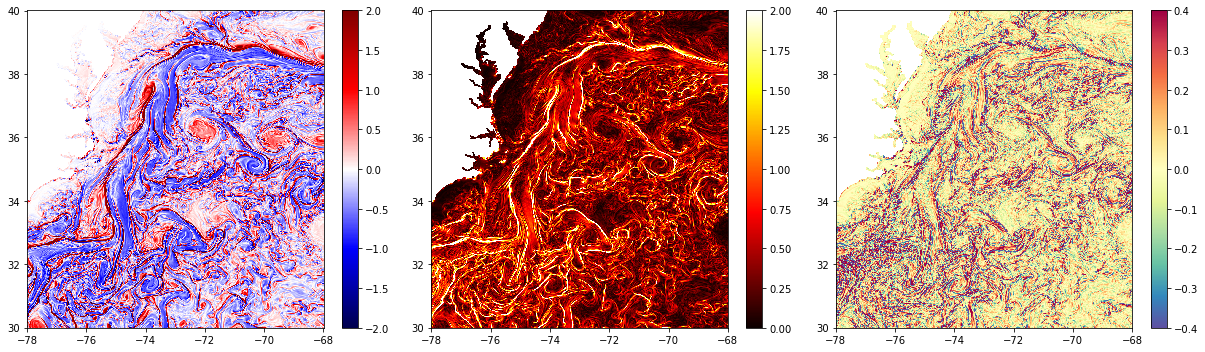

In [75]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(fesom01w.lon, fesom01w.lat, 
                     vorfesomw.isel(time=0)/fesomf, cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(fesom01w.lon, fesom01w.lat, 
                     strfesomw.isel(time=0)/fesomf, cmap='hot', vmin=0., vmax=2)
im3 = ax3.pcolormesh(fesom01w.lon, fesom01w.lat, 
                     divfesomw.isel(time=0)/fesomf, cmap='Spectral_r', vmin=-.4, vmax=.4)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

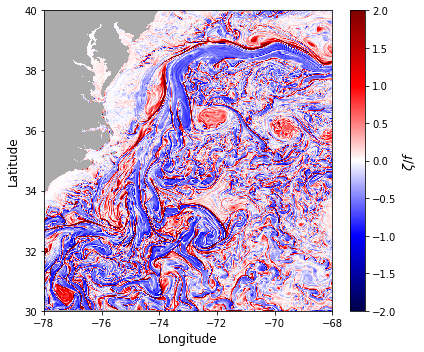

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(fesom01w.lon, fesom01w.lat, np.ma.masked_invalid(vorfesomw.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolormesh(fesom01w.lon, fesom01w.lat, vorfesomw.isel(time=0)/fesomf, 
                   cmap='seismic', vmax=2, vmin=-2, rasterized=True)

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-FESOM_01.pdf')

In [46]:
def fio_vort(u, v, DXT, DYT, coords=fio01w.eta_t[::12].coords):
    
    vx = diff(v, 1, axis=-1)
    uy = diff(u, 1, axis=-2) 
    
    return .5*(
        xr.DataArray(vx[...,:-1,1:].data + vx[...,1:,1:].data, 
                     dims=fio01w.eta_t.dims, coords=coords) / DXT
        - xr.DataArray(uy[...,1:,:-1].data + uy[...,1:,1:].data, 
                       dims=fio01w.eta_t.dims, coords=coords) / DYT
    ) 

def fio_str(u, v, DXT, DYT, coords=fio01w.eta_t[::12].coords):
    
    ux = diff(u, 1, axis=-1)
    vy = diff(v, 1, axis=-2) 
    vx = diff(v, 1, axis=-1)
    uy = diff(u, 1, axis=-2) 
    
    ux = xr.DataArray(ux[...,:-1,1:].data + ux[...,1:,1:].data, 
                      dims=fio01w.eta_t.dims, coords=coords) / DXT * .5
    vx = xr.DataArray(vx[...,:-1,1:].data + vx[...,1:,1:].data, 
                      dims=fio01w.eta_t.dims, coords=coords) / DXT * .5
    uy = xr.DataArray(uy[...,1:,:-1].data + uy[...,1:,1:].data, 
                      dims=fio01w.eta_t.dims, coords=coords) / DYT * .5
    vy = xr.DataArray(vy[...,1:,:-1].data + vy[...,1:,1:].data, 
                      dims=fio01w.eta_t.dims, coords=coords) / DYT * .5
    
    str1 = (ux - vy)
    str2 = (uy + vx)

    return np.sqrt(str1**2
        + str2**2
    )

In [47]:
DYT = xr.DataArray(fio01grid.DYT.data, dims=['yt_ocean','xt_ocean'],
                   coords=fio01w.eta_t.isel(time=0).coords)
DXT = xr.DataArray(fio01grid.DXT.data, dims=['yt_ocean','xt_ocean'],
                   coords=fio01w.eta_t.isel(time=0).coords)


vorfiow = fio_vort(fio01w.usurf[::12], 
                   fio01w.vsurf[::12], 
                   DXT, DYT)
strfiow = fio_str(fio01w.usurf[::12], 
                   fio01w.vsurf[::12], 
                   DXT, DYT)
vorfiow

<xarray.DataArray (time: 178, yt_ocean: 320, xt_ocean: 320)>
dask.array<mul, shape=(178, 320, 320), dtype=float32, chunksize=(23, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2018-02-01T13:00:00 ... 2018-05-01T01:00:00
  * xt_ocean  (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.08 -68.05 -68.02
  * yt_ocean  (yt_ocean) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98

In [49]:
vorfios = fio_vort(fio01s.usurf[::12], 
                   fio01s.vsurf[::12], 
                   DXT, DYT, coords=fio01s.eta_t[::12].coords)
strfios = fio_str(fio01s.usurf[::12], 
                   fio01s.vsurf[::12], 
                   DXT, DYT, coords=fio01s.eta_t[::12].coords)
vorfios

<xarray.DataArray (time: 184, yt_ocean: 320, xt_ocean: 320)>
dask.array<mul, shape=(184, 320, 320), dtype=float32, chunksize=(23, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2018-08-01T13:00:00 ... 2018-11-01T01:00:00
  * xt_ocean  (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.08 -68.05 -68.02
  * yt_ocean  (yt_ocean) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98

In [50]:
fiof = xr.apply_ufunc(gsw.f, fio01w.yt_ocean, dask='parallelized')
fiof

<xarray.DataArray 'yt_ocean' (yt_ocean: 320)>
array([7.29555911e-05, 7.30244571e-05, 7.30933013e-05, 7.31621238e-05,
       7.32309246e-05, 7.32997035e-05, 7.33684607e-05, 7.34371960e-05,
       7.35059095e-05, 7.35746011e-05, 7.36432708e-05, 7.37119187e-05,
       7.37805445e-05, 7.38491485e-05, 7.39177305e-05, 7.39862905e-05,
       7.40548284e-05, 7.41233444e-05, 7.41918383e-05, 7.42603101e-05,
       7.43287598e-05, 7.43971875e-05, 7.44655929e-05, 7.45339763e-05,
       7.46023375e-05, 7.46706764e-05, 7.47389932e-05, 7.48072877e-05,
       7.48755600e-05, 7.49438100e-05, 7.50120377e-05, 7.50802431e-05,
       7.51484262e-05, 7.52165869e-05, 7.52847252e-05, 7.53528411e-05,
       7.54209347e-05, 7.54890057e-05, 7.55570544e-05, 7.56250805e-05,
       7.56930842e-05, 7.57610653e-05, 7.58290239e-05, 7.58969599e-05,
       7.59648734e-05, 7.60327643e-05, 7.61006325e-05, 7.61684781e-05,
       7.62363011e-05, 7.63041013e-05, 7.63718789e-05, 7.64396338e-05,
       7.65073659e-05, 7.65750752e-05, 7.66427618e-05, 7.67104256e-05,
       7.67780665e-05, 7.68456847e-05, 7.69132799e-05, 7.69808523e-05,
       7.70484018e-05, 7.71159283e-05, 7.71834319e-05, 7.72509126e-05,
       7.73183703e-05, 7.73858049e-05, 7.74532166e-05, 7.75206052e-05,
       7.75879708e-05, 7.76553132e-05, 7.77226326e-05, 7.77899289e-05,
       7.78572020e-05, 7.79244519e-05, 7.79916787e-05, 7.80588823e-05,
       7.81260626e-05, 7.81932197e-05, 7.82603536e-05, 7.83274641e-05,
...
       8.88147172e-05, 8.88777977e-05, 8.89408519e-05, 8.90038796e-05,
       8.90668808e-05, 8.91298555e-05, 8.91928037e-05, 8.92557253e-05,
       8.93186205e-05, 8.93814890e-05, 8.94443310e-05, 8.95071463e-05,
       8.95699350e-05, 8.96326971e-05, 8.96954325e-05, 8.97581412e-05,
       8.98208233e-05, 8.98834786e-05, 8.99461071e-05, 9.00087089e-05,
       9.00712840e-05, 9.01338322e-05, 9.01963537e-05, 9.02588483e-05,
       9.03213160e-05, 9.03837569e-05, 9.04461709e-05, 9.05085580e-05,
       9.05709181e-05, 9.06332513e-05, 9.06955576e-05, 9.07578369e-05,
       9.08200892e-05, 9.08823144e-05, 9.09445126e-05, 9.10066838e-05,
       9.10688279e-05, 9.11309449e-05, 9.11930348e-05, 9.12550976e-05,
       9.13171332e-05, 9.13791417e-05, 9.14411230e-05, 9.15030770e-05,
       9.15650039e-05, 9.16269035e-05, 9.16887759e-05, 9.17506210e-05,
       9.18124388e-05, 9.18742292e-05, 9.19359924e-05, 9.19977282e-05,
       9.20594366e-05, 9.21211177e-05, 9.21827713e-05, 9.22443975e-05,
       9.23059963e-05, 9.23675676e-05, 9.24291115e-05, 9.24906278e-05,
       9.25521166e-05, 9.26135779e-05, 9.26750117e-05, 9.27364179e-05,
       9.27977965e-05, 9.28591475e-05, 9.29204708e-05, 9.29817666e-05,
       9.30430346e-05, 9.31042750e-05, 9.31654877e-05, 9.32266727e-05,
       9.32878299e-05, 9.33489594e-05, 9.34100611e-05, 9.34711351e-05,
       9.35321812e-05, 9.35931995e-05, 9.36541900e-05, 9.37151526e-05])
Coordinates:
  * yt_ocean  (yt_ocean) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98

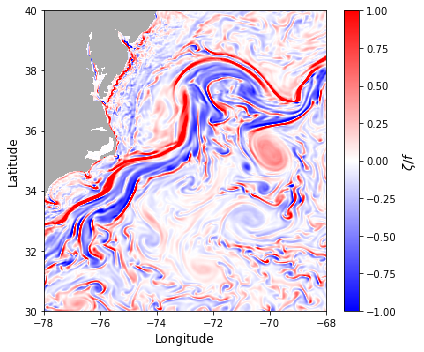

In [29]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean, np.ma.masked_invalid(vorfiow.isel(time=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean, vorfiow.isel(time=0)/fiof, 
                   cmap='bwr', vmax=1, vmin=-1, rasterized=True)

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-FIOCOM_01.pdf')

In [51]:
vbins = np.linspace(-4e0,4e0,40)
sbins = np.linspace(0,4e0,20)

In [52]:
histenatlw = xhist((strenatlw/enatlf).rename('strain').isel(y=slice(2,-2),
                                                            x=slice(2,-2)).chunk({'time_counter':10,'y':-1,'x':-1}), 
                   (vorenatlw/enatlf).rename('vort').isel(y=slice(2,-2),
                                                          x=slice(2,-2)).chunk({'time_counter':10,'y':-1,'x':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histenatls = xhist((strenatls/enatlf).rename('strain').isel(y=slice(2,-2),
                                                            x=slice(2,-2)).chunk({'time_counter':10,'y':-1,'x':-1}), 
                   (vorenatls/enatlf).rename('vort').isel(y=slice(2,-2),
                                                          x=slice(2,-2)).chunk({'time_counter':10,'y':-1,'x':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [73]:
histgigatlw = xhist((strgigaw/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                        xi_u=slice(2,-2)).chunk({'time':1,'eta_v':-1,'xi_u':-1}), 
                    (vorgigaw/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                      xi_u=slice(2,-2)).chunk({'time':1,'eta_v':-1,'xi_u':-1}), 
                    bins=[sbins, vbins]
                   ).compute()
histgigatls = xhist((strgigas/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                        xi_u=slice(2,-2)).chunk({'time':1,'eta_v':-1,'xi_u':-1}), 
                    (vorgigas/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                      xi_u=slice(2,-2)).chunk({'time':1,'eta_v':-1,'xi_u':-1}),  
                    bins=[sbins, vbins]
                   ).compute()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 19
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 19
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 19
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 19
  result = blockwise(


In [69]:
histhycomw = xhist((strhycomw/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}), 
                   (vorhycomw/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histhycoms = xhist((strhycoms/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}), 
                   (vorhycoms/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [70]:
histhycom25w = xhist((strhycom25w/hycomf_25).rename('strain').isel(Y=slice(2,-2),
                                                            X=slice(2,-2)).chunk({'time':10,'Y':-1,'X':-1}), 
                   (vorhycom25w/hycomf_25).rename('vort').isel(Y=slice(2,-2),
                                                          X=slice(2,-2)).chunk({'time':10,'Y':-1,'X':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histhycom25s = xhist((strhycom25s/hycomf_25).rename('strain').isel(Y=slice(2,-2),
                                                            X=slice(2,-2)).chunk({'time':10,'Y':-1,'X':-1}), 
                   (vorhycom25s/hycomf_25).rename('vort').isel(Y=slice(2,-2),
                                                          X=slice(2,-2)).chunk({'time':10,'Y':-1,'X':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [55]:
histfesomw = xhist((strfesomw/fesomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}), 
                   (vorfesomw/fesomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histfesoms = xhist((strfesoms/fesomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}), 
                   (vorfesoms/fesomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'time':10,'lat':-1,'lon':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [56]:
histllcw = xhist((gridllc.interp(gridllc.interp(strllcw,'X',boundary='extend'),'Y',boundary='extend')
                  / llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                 i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 (vorllcw/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 bins=[sbins, vbins]
                ).compute()
histllcs = xhist((gridllc.interp(gridllc.interp(strllcs,'X',boundary='extend'),'Y',boundary='extend')
                  / llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                 i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),
                 (vorllcs/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),  
                 bins=[sbins, vbins]
                ).compute()

In [58]:
histfiow = xhist((strfiow/fiof).rename('strain').isel(yt_ocean=slice(2,-2),
                                                      xt_ocean=slice(2,-2)).chunk({'time':10,'yt_ocean':-1,'xt_ocean':-1}), 
                 (vorfiow/fiof).rename('vort').isel(yt_ocean=slice(2,-2),
                                                    xt_ocean=slice(2,-2)).chunk({'time':10,'yt_ocean':-1,'xt_ocean':-1}), 
                 bins=[sbins, vbins]
                ).compute()
histfios = xhist((strfios/fiof).rename('strain').isel(yt_ocean=slice(2,-2),
                                                      xt_ocean=slice(2,-2)).chunk({'time':10,'yt_ocean':-1,'xt_ocean':-1}),
                 (vorfios/fiof).rename('vort').isel(yt_ocean=slice(2,-2),
                                                    xt_ocean=slice(2,-2)).chunk({'time':10,'yt_ocean':-1,'xt_ocean':-1}),  
                 bins=[sbins, vbins]
                ).compute()

/tmp/ipykernel_2582/3990405730.py:28: UserWarning: Log scale: values of z <= 0 have been masked
  im00 = ax00.contourf(histenatlw.vort_bin,
/tmp/ipykernel_2582/3990405730.py:36: UserWarning: Log scale: values of z <= 0 have been masked
  im10 = ax10.contourf(histhycomw.vort_bin,
/tmp/ipykernel_2582/3990405730.py:45: UserWarning: Log scale: values of z <= 0 have been masked
  im20 = ax20.contourf(histgigatlw.vort_bin,
/tmp/ipykernel_2582/3990405730.py:54: UserWarning: Log scale: values of z <= 0 have been masked
  im30 = ax30.contourf(histfesomw.vort_bin,
/tmp/ipykernel_2582/3990405730.py:63: UserWarning: Log scale: values of z <= 0 have been masked
  im40 = ax40.contourf(histllcw.vort_bin,
/tmp/ipykernel_2582/3990405730.py:72: UserWarning: Log scale: values of z <= 0 have been masked
  im50 = ax50.contourf(histfiow.vort_bin,
/tmp/ipykernel_2582/3990405730.py:81: UserWarning: Log scale: values of z <= 0 have been masked
  im60 = ax60.contourf(histhycom25w.vort_bin,
/tmp/ipykernel_2582/3

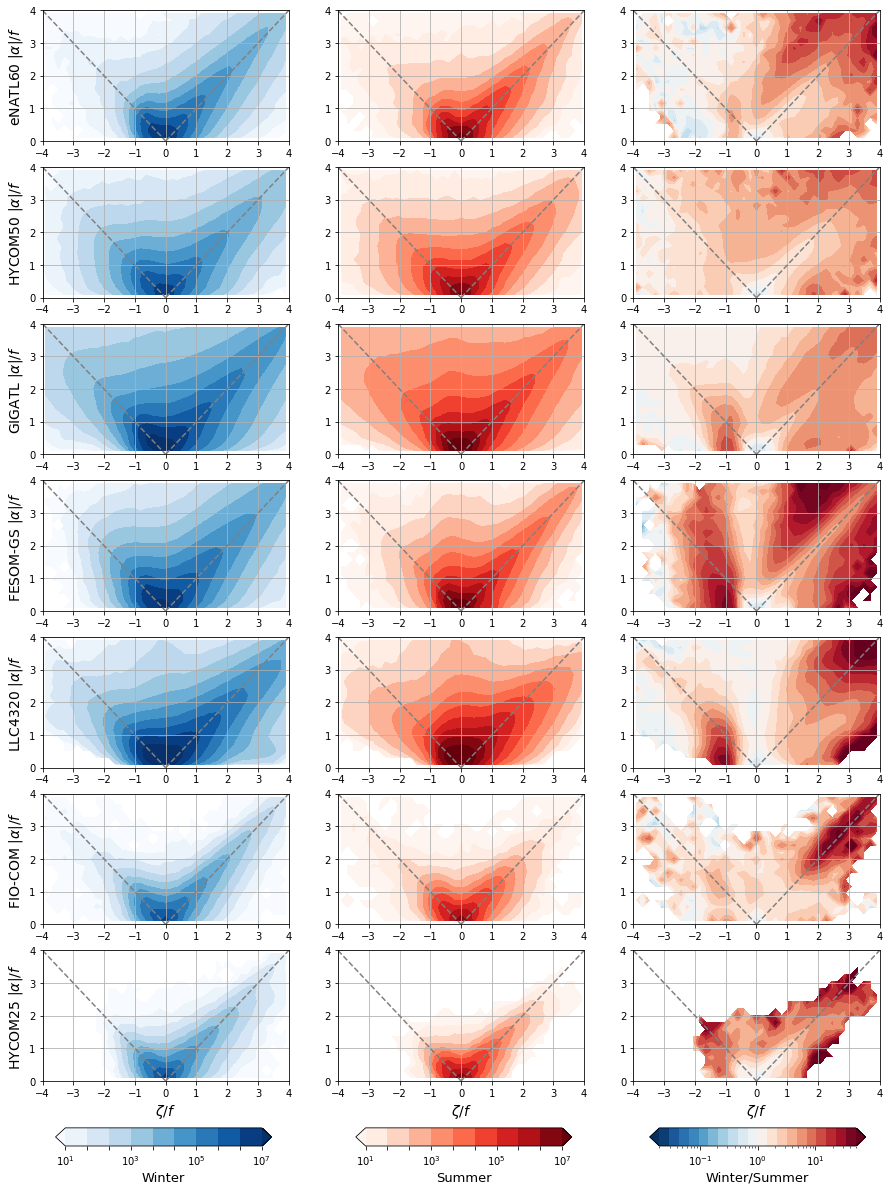

In [110]:
from matplotlib import ticker

fig, axes = plt.subplots(figsize=(15,21), nrows=7, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]
ax40 = axes[4,0]
ax41 = axes[4,1]
ax42 = axes[4,2]
ax50 = axes[5,0]
ax51 = axes[5,1]
ax52 = axes[5,2]
ax60 = axes[6,0]
ax61 = axes[6,1]
ax62 = axes[6,2]


im00 = ax00.contourf(histenatlw.vort_bin,
                      histenatlw.strain_bin,
                      histenatlw, 
                      cmap='Blues', locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
                    extend='both'
#                       rasterized=True
                   )
im10 = ax10.contourf(histhycomw.vort_bin,
                histhycomw.strain_bin,
                histhycomw, 
                cmap='Blues', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im20 = ax20.contourf(histgigatlw.vort_bin,
                histgigatlw.strain_bin,
                histgigatlw,
                cmap='Blues', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im30 = ax30.contourf(histfesomw.vort_bin,
                histfesomw.strain_bin,
                histfesomw,
                cmap='Blues', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im40 = ax40.contourf(histllcw.vort_bin,
                histllcw.strain_bin,
                histllcw,
                cmap='Blues', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im50 = ax50.contourf(histfiow.vort_bin,
                histfiow.strain_bin,
                histfiow,
                cmap='Blues', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im60 = ax60.contourf(histhycom25w.vort_bin,
                histhycom25w.strain_bin,
                histhycom25w,
                cmap='Blues', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )

im01 = ax01.contourf(histenatls.vort_bin,
                      histenatls.strain_bin,
                      histenatls, 
                      cmap='Reds', locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
                    extend='both'
#                       rasterized=True
                   )
im11 = ax11.contourf(histhycoms.vort_bin,
                histhycoms.strain_bin,
                histhycoms, 
                cmap='Reds', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im21 = ax21.contourf(histgigatls.vort_bin,
                histgigatls.strain_bin,
                histgigatls,
                cmap='Reds', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im31 = ax31.contourf(histfesoms.vort_bin,
                histfesoms.strain_bin,
                histfesoms,
                cmap='Reds', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im41 = ax41.contourf(histllcs.vort_bin,
                histllcs.strain_bin,
                histllcs,
                cmap='Reds', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im51 = ax51.contourf(histfios.vort_bin,
                histfios.strain_bin,
                histfios,
                cmap='Reds', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )
im61 = ax61.contourf(histhycom25s.vort_bin,
                histhycom25s.strain_bin,
                histhycom25s,
                cmap='Reds', 
                locator=ticker.LogLocator(), 
                    norm=clr.LogNorm(), levels=np.logspace(1,7,10),
              extend='both'
#                 rasterized=True
               )

im02 = ax02.contourf(histenatlw.vort_bin,
                      histenatlw.strain_bin, 
                      (histenatlw
                       / histenatls), 
                      cmap='RdBu_r', 
                     norm=clr.LogNorm(), levels=np.logspace(np.log10(2e-2),np.log10(5e1),21),
                     extend='both'
#                       rasterized=True
                    )
im12 = ax12.contourf(histhycomw.vort_bin,
                histhycomw.strain_bin, 
                (histhycomw
                 / histhycoms), 
                cmap='RdBu_r', 
                norm=clr.LogNorm(), levels=np.logspace(np.log10(2e-2),np.log10(5e1),21),
                     extend='both'
#                 rasterized=True
                    )
im22 = ax22.contourf(histgigatlw.vort_bin,
                histgigatlw.strain_bin, 
                (histgigatlw
                 / histgigatls), 
                cmap='RdBu_r', 
                     norm=clr.LogNorm(), levels=np.logspace(np.log10(2e-2),np.log10(5e1),21),
                     extend='both'
#                 rasterized=True
                    )
im32 = ax32.contourf(histfesomw.vort_bin,
                histfesomw.strain_bin, 
                (histfesomw
                 / histfesoms), 
                cmap='RdBu_r', 
                     norm=clr.LogNorm(), levels=np.logspace(np.log10(2e-2),np.log10(5e1),25),
                     extend='both'
#                 rasterized=True
                    )
im42 = ax42.contourf(histllcw.vort_bin,
                histllcw.strain_bin, 
                (histllcw
                 / histllcs), 
                cmap='RdBu_r', 
                     norm=clr.LogNorm(), levels=np.logspace(np.log10(2e-2),np.log10(5e1),21),
                     extend='both'
#                 rasterized=True
                    )
im52 = ax52.contourf(histfiow.vort_bin,
                histfiow.strain_bin, 
                (histfiow
                 / histfios), 
                cmap='RdBu_r', 
                     norm=clr.LogNorm(), levels=np.logspace(np.log10(2e-2),np.log10(5e1),21),
                     extend='both'
#                 rasterized=True
                    )
im62 = ax62.contourf(histhycom25w.vort_bin,
                histhycom25w.strain_bin, 
                (histhycom25w
                 / histhycom25s), 
                cmap='RdBu_r', 
                     norm=clr.LogNorm(), levels=np.logspace(np.log10(2e-2),np.log10(5e1),21),
                     extend='both'
#                 rasterized=True
                    )

for c in im00.collections:
    c.set_rasterized(True)
for c in im10.collections:
    c.set_rasterized(True)
for c in im20.collections:
    c.set_rasterized(True)
for c in im30.collections:
    c.set_rasterized(True)
for c in im40.collections:
    c.set_rasterized(True)
for c in im50.collections:
    c.set_rasterized(True)
for c in im60.collections:
    c.set_rasterized(True)
for c in im01.collections:
    c.set_rasterized(True)
for c in im11.collections:
    c.set_rasterized(True)
for c in im21.collections:
    c.set_rasterized(True)
for c in im31.collections:
    c.set_rasterized(True)
for c in im41.collections:
    c.set_rasterized(True)
for c in im51.collections:
    c.set_rasterized(True)
for c in im61.collections:
    c.set_rasterized(True)
for c in im02.collections:
    c.set_rasterized(True)
for c in im12.collections:
    c.set_rasterized(True)
for c in im22.collections:
    c.set_rasterized(True)
for c in im32.collections:
    c.set_rasterized(True)
for c in im42.collections:
    c.set_rasterized(True)
for c in im52.collections:
    c.set_rasterized(True)
for c in im62.collections:
    c.set_rasterized(True)

ax00.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax01.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax02.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax10.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax11.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax12.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax20.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax21.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax22.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax30.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax31.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax32.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax40.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax40.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax41.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax41.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax42.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax42.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax50.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax50.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax51.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax51.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax52.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax52.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax60.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax60.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax61.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax61.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax62.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax62.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-4,4])
ax01.set_xlim([-4,4])
ax02.set_xlim([-4,4])
ax10.set_xlim([-4,4])
ax11.set_xlim([-4,4])
ax12.set_xlim([-4,4])
ax20.set_xlim([-4,4])
ax21.set_xlim([-4,4])
ax22.set_xlim([-4,4])
ax30.set_xlim([-4,4])
ax31.set_xlim([-4,4])
ax32.set_xlim([-4,4])
ax40.set_xlim([-4,4])
ax41.set_xlim([-4,4])
ax42.set_xlim([-4,4])
ax50.set_xlim([-4,4])
ax51.set_xlim([-4,4])
ax52.set_xlim([-4,4])
ax60.set_xlim([-4,4])
ax61.set_xlim([-4,4])
ax62.set_xlim([-4,4])
ax00.set_ylim([0,4])
ax01.set_ylim([0,4])
ax02.set_ylim([0,4])
ax10.set_ylim([0,4])
ax11.set_ylim([0,4])
ax12.set_ylim([0,4])
ax20.set_ylim([0,4])
ax21.set_ylim([0,4])
ax22.set_ylim([0,4])
ax30.set_ylim([0,4])
ax31.set_ylim([0,4])
ax32.set_ylim([0,4])
ax40.set_ylim([0,4])
ax41.set_ylim([0,4])
ax42.set_ylim([0,4])
ax50.set_ylim([0,4])
ax51.set_ylim([0,4])
ax52.set_ylim([0,4])
ax60.set_ylim([0,4])
ax61.set_ylim([0,4])
ax62.set_ylim([0,4])

ax60.set_xlabel(r"$\zeta/f$", fontsize=14)
ax61.set_xlabel(r"$\zeta/f$", fontsize=14)
ax62.set_xlabel(r"$\zeta/f$", fontsize=14)
ax00.set_ylabel(r"eNATL60 $|\alpha|/f$", fontsize=14)
ax10.set_ylabel(r"HYCOM50 $|\alpha|/f$", fontsize=14)
ax20.set_ylabel(r"GIGATL $|\alpha|/f$", fontsize=14)
ax30.set_ylabel(r"FESOM-GS $|\alpha|/f$", fontsize=14)
ax40.set_ylabel(r"LLC4320 $|\alpha|/f$", fontsize=14)
ax50.set_ylabel(r"FIO-COM $|\alpha|/f$", fontsize=14)
ax60.set_ylabel(r"HYCOM25 $|\alpha|/f$", fontsize=14)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)
ax40.grid(True)
ax41.grid(True)
ax42.grid(True)
ax50.grid(True)
ax51.grid(True)
ax52.grid(True)
ax60.grid(True)
ax61.grid(True)
ax62.grid(True)

fig.subplots_adjust(bottom=.172, hspace=.2) 
cbax0 = fig.add_axes([0.137, 0.129, 0.2, 0.012])
cbar0 = fig.colorbar(im00, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=13)

cbax1 = fig.add_axes([0.415, 0.129, 0.2, 0.012])
cbar1 = fig.colorbar(im01, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=13)

cbax2 = fig.add_axes([0.687, 0.129, 0.2, 0.012])
cbar2 = fig.colorbar(im02, orientation='horizontal', cax=cbax2, ticks=[1e-1,1e0,1e1])
cbar2.set_label(r"Winter/Summer", fontsize=13)

plt.savefig('/home/jovyan/Figures/vort-strain-jointPDF_01.pdf')